# Movie Recommendation Machine Learning Project Using K-Means

### The data science workflow for this project has 4 main steps:

    1. Loading the data
    2. Exploratory data analysis (EDA) – Data cleaning and exploration
          Cleaning the data
          Visualizing the data
          Feature engineering
    3. Data modelling
          Population segmentation using unsupervised clustering
    4. Drawing conclusions from our modelling
          Accessing the KMeans model attributes


In [1]:
import os
import boto3
import io
import sagemaker

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sagemaker import get_execution_role
from sagemaker import KMeans

## Step 1 - Loading The Data

**I experienced EC2 Instance resource issues reading the title.akas.tsv file described below:  
ml.t2.medium failed  
ml.t2.large worked**

### For the read of the IMDB title.akas.tsv data I am only interested in the titleId and the language columns so all other columns will filtered out in the read_csv command.

In [2]:
df_akas = pd.read_csv('https://datasets.imdbws.com/title.akas.tsv.gz', sep='\t', index_col='titleId', usecols = ['titleId','language'])

In [3]:
df_title = pd.read_csv('https://datasets.imdbws.com/title.basics.tsv.gz', sep='\t', index_col='tconst')

In [4]:
df_ratings = pd.read_csv('https://datasets.imdbws.com/title.ratings.tsv.gz', sep='\t', index_col='tconst')

In [5]:
df_akas.head()

,language
titleId,
tt0000001,\N
tt0000001,\N
tt0000001,\N
tt0000001,\N
tt0000001,\N


In [6]:
df_title.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [7]:
df_ratings.head()

,averageRating,numVotes
tconst,,
tt0000001,5.6,1660
tt0000002,6.1,203
tt0000003,6.5,1372
tt0000004,6.2,123
tt0000005,6.2,2161


In [8]:
df_akas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24131964 entries, tt0000001 to tt9916856
Data columns (total 1 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   language  object
dtypes: object(1)
memory usage: 368.2+ MB


In [9]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7339583 entries, tt0000001 to tt9916880
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   titleType       object
 1   primaryTitle    object
 2   originalTitle   object
 3   isAdult         int64 
 4   startYear       object
 5   endYear         object
 6   runtimeMinutes  object
 7   genres          object
dtypes: int64(1), object(7)
memory usage: 504.0+ MB


In [10]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090185 entries, tt0000001 to tt9916778
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   averageRating  1090185 non-null  float64
 1   numVotes       1090185 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 25.0+ MB


In [11]:
df_akas.shape

(24131964, 1)

In [12]:
df_title.shape

(7339583, 8)

In [13]:
df_ratings.shape

(1090185, 2)

## Step 2 - Exploratory data analysis (EDA) – Data cleaning and exploration

## For this project the final dataset will be filtered to only contain English language, non-adult movies.

### I have a hypothesis about the ratings data that I hope to prove via visualization.  My hypothesis is that movies with more votes have higher ratings because they are popular and since they are popular they get more votes.

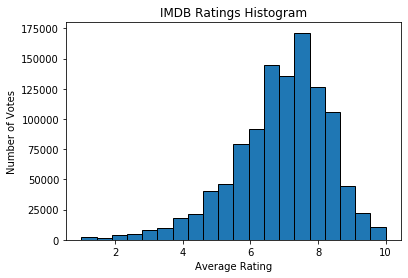

In [14]:
plt.hist(df_ratings['averageRating'], bins=20, edgecolor='black')
plt.title('IMDB Ratings Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.show()

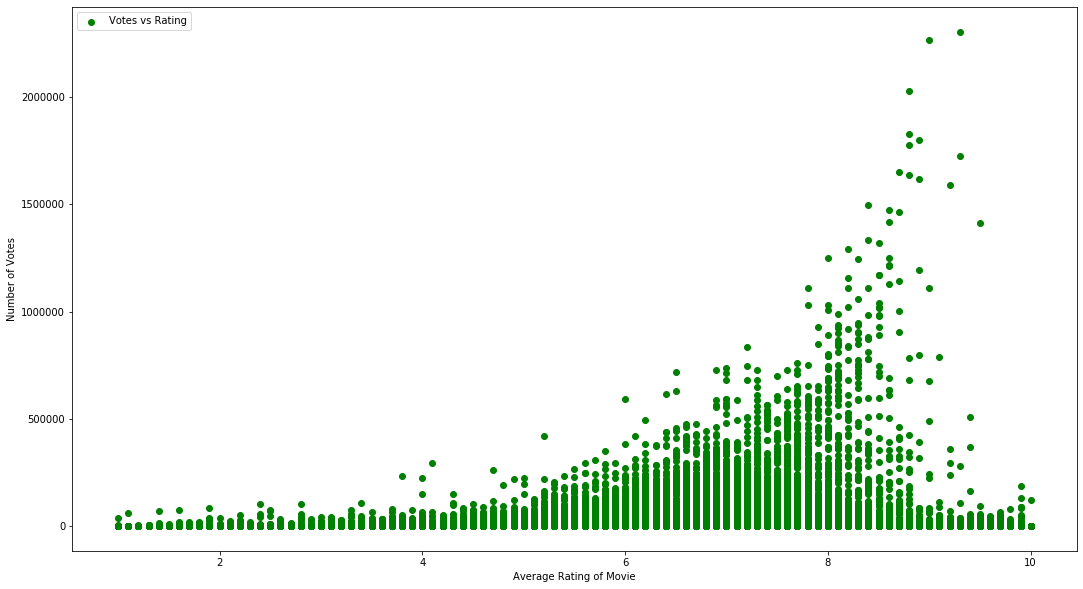

In [15]:
plt.figure(figsize = (18,10))
plt.scatter(df_ratings['averageRating'], df_ratings['numVotes'], c='g', label='Votes vs Rating')
plt.xlabel('Average Rating of Movie')
plt.ylabel('Number of Votes')
plt.legend(loc='upper left')
plt.show()

Text(0, 0.5, 'Number of Votes')

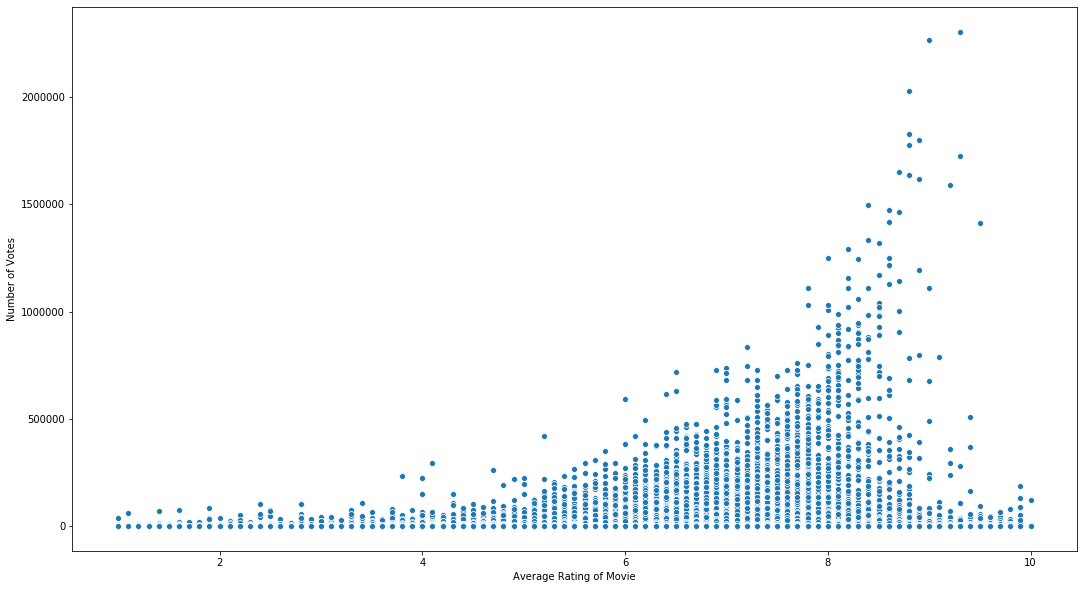

In [16]:
plt.figure(figsize = (18,10))
sns.scatterplot(x = df_ratings['averageRating'], y = df_ratings['numVotes'])
plt.xlabel('Average Rating of Movie')
plt.ylabel('Number of Votes')

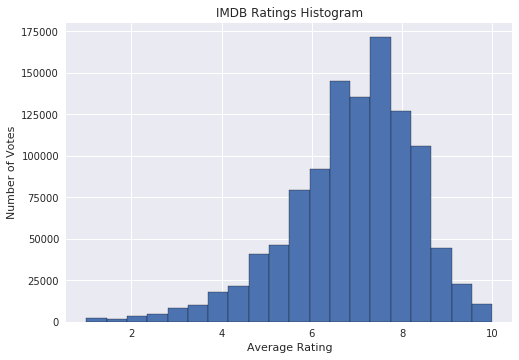

In [17]:
with plt.style.context('seaborn'):
    plt.hist(df_ratings['averageRating'], bins=20, edgecolor = 'black')
    plt.title('IMDB Ratings Histogram')
    plt.xlabel('Average Rating')
    plt.ylabel('Number of Votes')

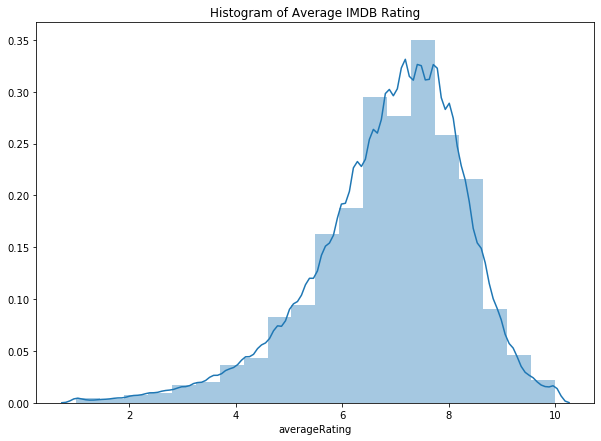

In [18]:
plt.figure(figsize = (10,7))
ax=sns.distplot(df_ratings['averageRating'], bins=20)
title="Histogram of Average IMDB Rating"
ax.set_title(title, fontsize=12)
plt.show()

**Merge the ratings and title dataframes.  
The following merge is similar to a SQL INNER JOIN**

In [19]:
df_rt = pd.merge(df_ratings, df_title, left_index=True, right_index=True)

In [20]:
df_rt.shape

(1090184, 10)

In [21]:
df_rt.head()

,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,,,
tt0000001,5.6,1660,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
tt0000002,6.1,203,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
tt0000003,6.5,1372,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
tt0000004,6.2,123,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
tt0000005,6.2,2161,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


#### Select the rows where isAdult is equal to 0 and overwrite the dataframe.

In [22]:
df_rt.isAdult.unique()

array([   0,    1, 2020, 2014])

In [23]:
df_rt = df_rt.query('isAdult == 0')

In [24]:
df_rt.isAdult.unique()

array([0])

#### Select the rows where titleType is equal to movie and overwrite the dataframe.

In [25]:
df_rt.titleType.unique()

array(['short', 'movie', 'tvShort', 'tvSeries', 'tvMovie', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame'], dtype=object)

In [26]:
df_rt.shape

(1071543, 10)

In [27]:
df_rt = df_rt.query('titleType == "movie"')

In [28]:
df_rt.titleType.unique()

array(['movie'], dtype=object)

In [29]:
df_rt.shape

(251281, 10)

#### Drop the titleType, originalTitle, isAdult, startYear, endYear and runtimeMinutes columns.

In [30]:
df_rt.drop(['titleType', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes'], axis = 1, inplace=True)

In [31]:
df_rt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251281 entries, tt0000009 to tt9916538
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   averageRating  251281 non-null  float64
 1   numVotes       251281 non-null  int64  
 2   primaryTitle   251281 non-null  object 
 3   genres         251281 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 9.6+ MB


#### Basically we now have a DataFrame that contains English movie title with their ratings and genres

In [32]:
df = df_rt

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251281 entries, tt0000009 to tt9916538
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   averageRating  251281 non-null  float64
 1   numVotes       251281 non-null  int64  
 2   primaryTitle   251281 non-null  object 
 3   genres         251281 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 9.6+ MB


In [34]:
list(df.columns)

['averageRating', 'numVotes', 'primaryTitle', 'genres']

In [35]:
df.head()

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0000009,5.9,155,Miss Jerry,Romance
tt0000335,6.0,39,Soldiers of the Cross,"Biography,Drama"
tt0000502,4.7,7,Bohemios,\N
tt0000574,6.1,595,The Story of the Kelly Gang,"Biography,Crime,Drama"
tt0000615,4.5,14,Robbery Under Arms,Drama


In [36]:
df.shape

(251281, 4)

Saving a Pandas Dataframe as a CSV

df.to_csv('mergeOfTitleAndRatings.csv')

In [37]:
df.genres.unique()

array(['Romance', 'Biography,Drama', '\\N', ..., 'Fantasy,History,War',
       'Documentary,Family,Sci-Fi', 'Horror,Musical,Thriller'],
      dtype=object)

In [38]:
df.genres.unique().shape

(1181,)

#### One Hot Encoding (OHE) logic used below came from  
https://stackoverflow.com/questions/47786822/how-do-you-one-hot-encode-columns-with-a-list-of-strings-as-values

In [39]:
df.head()

,averageRating,numVotes,primaryTitle,genres
tconst,,,,
tt0000009,5.9,155,Miss Jerry,Romance
tt0000335,6.0,39,Soldiers of the Cross,"Biography,Drama"
tt0000502,4.7,7,Bohemios,\N
tt0000574,6.1,595,The Story of the Kelly Gang,"Biography,Crime,Drama"
tt0000615,4.5,14,Robbery Under Arms,Drama


In [40]:
df.genres

tconst
tt0000009                      Romance
tt0000335              Biography,Drama
tt0000502                           \N
tt0000574        Biography,Crime,Drama
tt0000615                        Drama
                       ...            
tt9916160                  Documentary
tt9916190    Action,Adventure,Thriller
tt9916362         Drama,History,Horror
tt9916428        Adventure,History,War
tt9916538                        Drama
Name: genres, Length: 251281, dtype: object

In [41]:
ohe_genres_df = df.genres.str.get_dummies(',').add_prefix('genre_')

In [42]:
ohe_genres_df

,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western,genre_\N
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
tt0000335,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
tt0000574,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000615,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9916160,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9916190,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
tt9916362,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Drop the genre_Adult column because this project is not using adult movies.

In [43]:
ohe_genres_df.drop(['genre_Adult'], axis = 1, inplace=True)

#### Drop the genre_\N column

In [44]:
ohe_genres_df.drop(['genre_\\N'], axis = 1, inplace=True)

In [45]:
ohe_genres_df.head()

,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000335,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000615,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
ohe_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251281 entries, tt0000009 to tt9916538
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   genre_Action       251281 non-null  int64
 1   genre_Adventure    251281 non-null  int64
 2   genre_Animation    251281 non-null  int64
 3   genre_Biography    251281 non-null  int64
 4   genre_Comedy       251281 non-null  int64
 5   genre_Crime        251281 non-null  int64
 6   genre_Documentary  251281 non-null  int64
 7   genre_Drama        251281 non-null  int64
 8   genre_Family       251281 non-null  int64
 9   genre_Fantasy      251281 non-null  int64
 10  genre_Film-Noir    251281 non-null  int64
 11  genre_Game-Show    251281 non-null  int64
 12  genre_History      251281 non-null  int64
 13  genre_Horror       251281 non-null  int64
 14  genre_Music        251281 non-null  int64
 15  genre_Musical      251281 non-null  int64
 16  genre_Mystery      251281 non-nu

#### Add these one hot encoded genres to the df DataFrame

In [47]:
df = pd.concat([df, ohe_genres_df], axis=1, sort=False)

In [48]:
df.head()

,averageRating,numVotes,primaryTitle,genres,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,5.9,155,Miss Jerry,Romance,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000335,6.0,39,Soldiers of the Cross,"Biography,Drama",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000502,4.7,7,Bohemios,\N,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,6.1,595,The Story of the Kelly Gang,"Biography,Crime,Drama",0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0000615,4.5,14,Robbery Under Arms,Drama,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Drop the genres column because it is now redundant with the addition of the one hot encoded genres feature

In [49]:
df.drop(['genres'], axis = 1, inplace=True)

In [50]:
df.head()

,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt0000009,5.9,155,Miss Jerry,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0000335,6.0,39,Soldiers of the Cross,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000502,4.7,7,Bohemios,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0000574,6.1,595,The Story of the Kelly Gang,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt0000615,4.5,14,Robbery Under Arms,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251281 entries, tt0000009 to tt9916538
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   averageRating      251281 non-null  float64
 1   numVotes           251281 non-null  int64  
 2   primaryTitle       251281 non-null  object 
 3   genre_Action       251281 non-null  int64  
 4   genre_Adventure    251281 non-null  int64  
 5   genre_Animation    251281 non-null  int64  
 6   genre_Biography    251281 non-null  int64  
 7   genre_Comedy       251281 non-null  int64  
 8   genre_Crime        251281 non-null  int64  
 9   genre_Documentary  251281 non-null  int64  
 10  genre_Drama        251281 non-null  int64  
 11  genre_Family       251281 non-null  int64  
 12  genre_Fantasy      251281 non-null  int64  
 13  genre_Film-Noir    251281 non-null  int64  
 14  genre_Game-Show    251281 non-null  int64  
 15  genre_History      251281 non-null  int64  
 

**Time to merge the titleId and language from the title.akas.tsv file  
First, test for duplicate indexes in the df_akas DataFrame  
Second, select the English movies**

In [52]:
df.shape

(251281, 30)

In [53]:
df_akas.shape

(24131964, 1)

In [54]:
df_akas.language.unique()

array(['\\N', 'ja', 'sv', 'en', 'tr', 'es', 'sr', 'cs', 'sk', 'fr', 'fa',
       'bg', 'ca', 'nl', 'qbn', 'pt', 'ru', 'uk', 'qbp', 'ar', 'cmn',
       'rn', 'bs', 'de', 'hi', 'yi', 'qbo', 'ka', 'hr', 'sl', 'he', 'tg',
       'kk', 'da', 'el', 'fi', 'it', 'be', 'gsw', 'gl', 'eu', 'yue', 'az',
       'ms', 'pl', 'mr', 'uz', 'th', 'ta', 'af', 'la', 'hy', 'ur', 'bn',
       'te', 'ml', 'lt', 'mk', 'et', 'lv', 'tl', 'id', 'gd', 'ga', 'cy',
       'qal', 'gu', 'kn', 'ro', 'hu', 'pa', 'wo', 'no', 'is', 'sq', 'vi',
       'zh', 'ps', 'zu', 'nqo', 'sd', 'xh', 'mi', 'ku', 'rm', 'su', 'jv',
       'prs', 'ky', 'fro', 'ko', 'haw', 'mn', 'lo', 'my', 'am', 'qac',
       'ne', 'myv', 'br', 'iu', 'st', 'tn', 'cr'], dtype=object)

In [55]:
df_akas.query('index =="tt0060196"')

,language
titleId,
tt0060196,\N
tt0060196,sv
tt0060196,tr
tt0060196,sv
tt0060196,\N
...,...
tt0060196,sr
tt0060196,\N
tt0060196,\N


#### Select the rows where language is equal to en and overwrite the dataframe.

In [56]:
df_akas = df_akas.query('language == "en"')

In [57]:
df_akas.shape

(243974, 1)

Test for duplicates

In [58]:
df_akas.query('index =="tt0060196"')

,language
titleId,
tt0060196,en
tt0060196,en
tt0060196,en
tt0060196,en
tt0060196,en
tt0060196,en


In [59]:
df_akas.language.unique()

array(['en'], dtype=object)

#### Remove duplicate indexes from the df_akas DataFrame

In [60]:
df_akas = df_akas.groupby(df_akas.index).first()

In [61]:
df_akas.shape

(185498, 1)

Test again for duplicates

In [62]:
df_akas.query('index =="tt0060196"')

,language
titleId,
tt0060196,en


#### The following merge is similar to a SQL INNER JOIN

In [63]:
df = pd.merge(df_akas, df, left_index=True, right_index=True)

In [64]:
df.head()

,language,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tt0000941,en,4.2,12,Locura de amor,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001122,en,5.3,7,The Red Inn,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001175,en,5.8,22,Camille,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0001258,en,5.8,87,The White Slave Trade,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001338,en,5.3,6,A Night in May,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df.query('primaryTitle =="The Good, the Bad and the Ugly"')

,language,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tt0060196,en,8.8,679138,"The Good, the Bad and the Ugly",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [66]:
df.query('index =="tt0060196"')

,language,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tt0060196,en,8.8,679138,"The Good, the Bad and the Ugly",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
df.drop(['language'], axis = 1, inplace=True)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86951 entries, tt0000941 to tt9916428
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      86951 non-null  float64
 1   numVotes           86951 non-null  int64  
 2   primaryTitle       86951 non-null  object 
 3   genre_Action       86951 non-null  int64  
 4   genre_Adventure    86951 non-null  int64  
 5   genre_Animation    86951 non-null  int64  
 6   genre_Biography    86951 non-null  int64  
 7   genre_Comedy       86951 non-null  int64  
 8   genre_Crime        86951 non-null  int64  
 9   genre_Documentary  86951 non-null  int64  
 10  genre_Drama        86951 non-null  int64  
 11  genre_Family       86951 non-null  int64  
 12  genre_Fantasy      86951 non-null  int64  
 13  genre_Film-Noir    86951 non-null  int64  
 14  genre_Game-Show    86951 non-null  int64  
 15  genre_History      86951 non-null  int64  
 16  genre_Horror   

In [69]:
df.shape

(86951, 30)

#### Feature engineering

Modify the index to contain the text and leave all columns containing data

In [70]:
df_titles = df

In [71]:
df.index=df.index + "-" + df['primaryTitle']

In [72]:
df

,averageRating,numVotes,primaryTitle,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tt0000941-Locura de amor,4.2,12,Locura de amor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001122-The Red Inn,5.3,7,The Red Inn,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001175-Camille,5.8,22,Camille,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
tt0001258-The White Slave Trade,5.8,87,The White Slave Trade,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001338-A Night in May,5.3,6,A Night in May,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9910530-Svartklubb,5.5,15,Svartklubb,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9911196-The Marriage Escape,7.7,958,The Marriage Escape,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9914254-A Cherry Tale,7.9,7,A Cherry Tale,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt9914942-La vida sense la Sara Amat,6.8,106,La vida sense la Sara Amat,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df.drop(['primaryTitle'],axis=1,inplace=True)

In [74]:
df

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
tt0000941-Locura de amor,4.2,12,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0001122-The Red Inn,5.3,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0001175-Camille,5.8,22,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
tt0001258-The White Slave Trade,5.8,87,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0001338-A Night in May,5.3,6,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9910530-Svartklubb,5.5,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt9911196-The Marriage Escape,7.7,958,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt9914254-A Cherry Tale,7.9,7,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tt9914942-La vida sense la Sara Amat,6.8,106,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Check that each genre column has two value.  If it only has array([0]) then that genre column can be deleted

In [75]:
for col in df.columns:
    if col.startswith( 'genre_' ):
        if (df[col].unique() == [0]).all():
            print(f'Recommend dropping the {col} column because it only contains zeros.')
        else:
            #print(f'Recommend keeping the {col} column because it contains both zeros and ones')
            pass

Recommend dropping the genre_Game-Show column because it only contains zeros.
Recommend dropping the genre_Talk-Show column because it only contains zeros.


#### Based on the above results the genre_Game-Show and the genre_Talk-Show columns can be dropped.

In [76]:
df.drop(['genre_Game-Show','genre_Talk-Show'], axis=1, inplace=True)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86951 entries, tt0000941-Locura de amor to tt9916428-The Secret of China
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      86951 non-null  float64
 1   numVotes           86951 non-null  int64  
 2   genre_Action       86951 non-null  int64  
 3   genre_Adventure    86951 non-null  int64  
 4   genre_Animation    86951 non-null  int64  
 5   genre_Biography    86951 non-null  int64  
 6   genre_Comedy       86951 non-null  int64  
 7   genre_Crime        86951 non-null  int64  
 8   genre_Documentary  86951 non-null  int64  
 9   genre_Drama        86951 non-null  int64  
 10  genre_Family       86951 non-null  int64  
 11  genre_Fantasy      86951 non-null  int64  
 12  genre_Film-Noir    86951 non-null  int64  
 13  genre_History      86951 non-null  int64  
 14  genre_Horror       86951 non-null  int64  
 15  genre_Music        86951 non

In [78]:
df.shape

(86951, 27)

### Feature engineering

**Data Scaling** – We need to standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. We can use minmaxscaler to transform the numerical columns so that they also fall between 0 and 1.

In [79]:
scaler=MinMaxScaler()
df_movies_scaled=pd.DataFrame(scaler.fit_transform(df))
df_movies_scaled.columns=df.columns
df_movies_scaled.index=df.index

In [80]:
df_movies_scaled.describe()

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
count,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,...,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000,86951.000000
mean,0.575892,0.003977,0.143449,0.078653,0.025543,0.030373,0.263079,0.109774,0.080942,0.527757,...,0.045462,0.001070,0.000046,0.134904,0.028775,0.000012,0.010489,0.096606,0.029085,0.013835
std,0.131037,0.023375,0.350532,0.269199,0.157769,0.171614,0.440308,0.312610,0.272748,0.499232,...,0.208317,0.032687,0.006782,0.341623,0.167174,0.003391,0.101876,0.295422,0.168047,0.116808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.588889,0.000070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.000503,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
df_movies_scaled.head()

,averageRating,numVotes,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_War,genre_Western
tt0000941-Locura de amor,0.355556,3.037560e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0001122-The Red Inn,0.477778,8.678744e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0001175-Camille,0.533333,7.376932e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0001258-The White Slave Trade,0.533333,3.558285e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0001338-A Night in May,0.477778,4.339372e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 3 - Data modelling

In [82]:
df_movies_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86951 entries, tt0000941-Locura de amor to tt9916428-The Secret of China
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   averageRating      86951 non-null  float64
 1   numVotes           86951 non-null  float64
 2   genre_Action       86951 non-null  float64
 3   genre_Adventure    86951 non-null  float64
 4   genre_Animation    86951 non-null  float64
 5   genre_Biography    86951 non-null  float64
 6   genre_Comedy       86951 non-null  float64
 7   genre_Crime        86951 non-null  float64
 8   genre_Documentary  86951 non-null  float64
 9   genre_Drama        86951 non-null  float64
 10  genre_Family       86951 non-null  float64
 11  genre_Fantasy      86951 non-null  float64
 12  genre_Film-Noir    86951 non-null  float64
 13  genre_History      86951 non-null  float64
 14  genre_Horror       86951 non-null  float64
 15  genre_Music        86951 non

In [83]:
train_data = df_movies_scaled.values.astype('float32')

In [84]:
list(train_data)

[array([3.5555556e-01, 3.0375602e-06, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([4.7777778e-01, 8.6787435e-07, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([5.3333336e-01, 7.3769320e-06, 0.0000

#### Call and define the hyperparameters of our KMeans model as we have done with our PCA model. The Kmeans algorithm allows for the setting of how many clusters to identify.

In [85]:
role = get_execution_role()
bucket_name = 'bg-sagemaker-bucket-us-east-1'
num_clusters = 15
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/kmeans-movie-titles/',              
                k=num_clusters)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Next, train the model on our training data.  Can take several minutes.

In [86]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-11-14 22:31:06 Starting - Starting the training job...
2020-11-14 22:31:09 Starting - Launching requested ML instances.........
2020-11-14 22:32:41 Starting - Preparing the instances for training...
2020-11-14 22:33:28 Downloading - Downloading input data...
2020-11-14 22:33:40 Training - Downloading the training image...
2020-11-14 22:34:37 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/14/2020 22:34:34 INFO 139913579104064] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_

#### Now we deploy the model and pass in the original training set to get the labels for each entry. This will give us which cluster each movie belongs to.  Can take several minutes.

In [87]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 271 ms, sys: 10 ms, total: 281 ms
Wall time: 7min 32s


In [88]:
%%time
result=kmeans_predictor.predict(train_data)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (413) from model with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>413 Request Entity Too Large</title>
<h1>Request Entity Too Large</h1>
<p>The data value transmitted exceeds the capacity limit.</p>
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/kmeans-2020-11-14-22-35-18-461 in account 579326408185 for more information.

#### We can see the breakdown of cluster counts and the distribution of clusters.

In [181]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

NameError: name 'result' is not defined